In [2]:
import random
from random import shuffle
import torch
from torch_geometric.data import Data
from torch_geometric.utils import convert, coalesce
import math
import networkx as nx
import numpy as np
import exp
import matplotlib.pyplot as plt
from models.utils import set_seed

In [6]:
NUM_NODES = 10

In [9]:
def generate_bipartite_graphs(hypergraph_order: int):
    source_nodes = torch.tensor([], dtype=torch.int64)
    destination_nodes = torch.tensor([], dtype=torch.int64)

    # Generate "hypergraph_order" perfect matchings
    for i in range(hypergraph_order):
        left_nodes = torch.tensor([j for j in range(NUM_NODES)])
        right_nodes = torch.tensor([NUM_NODES + j for j in range(NUM_NODES)])
        left_perm = torch.randperm(left_nodes.shape[0])
        right_perm = torch.randperm(right_nodes.shape[0])
        source_nodes = torch.concat((source_nodes, left_nodes[left_perm]))
        destination_nodes = torch.concat((destination_nodes, right_nodes[right_perm]))

    expander_edge_index = torch.cat([source_nodes[None, ...], destination_nodes[None, ...]], dim=0)
    expander_edge_index = coalesce(expander_edge_index)
    return expander_edge_index

In [10]:
edge_index = generate_bipartite_graphs(3)

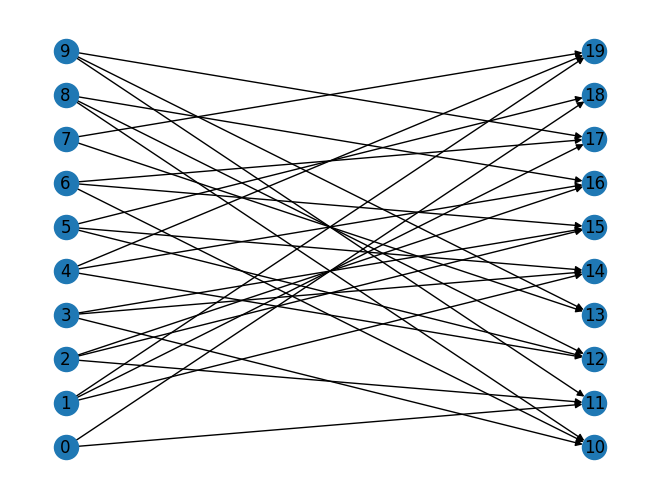

In [11]:
data = Data(edge_index=edge_index, num_nodes=NUM_NODES * 2)
nx_graph = convert.to_networkx(data)
pos = nx.bipartite_layout(nx_graph, [i for i in range(NUM_NODES)])
nx.draw(nx_graph, pos=pos, with_labels=True)

In [19]:
def generate_ramanujan_bipartite_graphs(hypergraph_order: int, random_seed: int):
    connected = False
    ramanujan = False
    random_seed_offset = 0
    while not (connected and ramanujan):
        random.seed(random_seed + random_seed_offset)
        all_destination_nodes = []
        for i in range(hypergraph_order):
            valid_shuffle = False
            while not valid_shuffle:
                destination_nodes = [NUM_NODES + j for j in range(NUM_NODES)]
                shuffle(destination_nodes)
                print(f"Destinatio")
                if i == 0:
                    valid_shuffle = True
                else:
                    # Checks to ensure that all hyperedges consist of 'hypergraph_order' unique nodes so bipartite graph is regular
                    valid_shuffle = True
                    for j in range(hypergraph_order - 1, 0, -1):
                        nodes_in_edge = all_destination_nodes[-j:] + destination_nodes[:hypergraph_order - j]
                        print(f"j: {j} Nodes in edge: {nodes_in_edge}")
                        valid_shuffle = valid_shuffle and (len(nodes_in_edge) == len(set(nodes_in_edge)))
                        print(f"Valid Shuffle: {valid_shuffle}")
                    # first_combination_valid = (all_destination_nodes[-2] != destination_nodes[0]) and (all_destination_nodes[-1] != destination_nodes[0])
                    # second_combination_valid = (all_destination_nodes[-1] != destination_nodes[0]) and (all_destination_nodes[-1] != destination_nodes[1])
                    # valid_shuffle = first_combination_valid and second_combination_valid
            all_destination_nodes.extend(destination_nodes)

        all_source_nodes = [i for i in range(NUM_NODES)]
        all_source_nodes = torch.tensor(np.repeat(all_source_nodes, hypergraph_order).tolist())
        print(f"All Source Nodes: {all_source_nodes}")
        all_destination_nodes = torch.tensor(all_destination_nodes)
        print(f"All destination nodes shape: {all_destination_nodes.shape}")

        expander_edge_index = torch.cat([all_source_nodes[None, ...], all_destination_nodes[None, ...]], dim=0)
        print(f"Expander edge shape before: {expander_edge_index.shape}")
        expander_edge_index = coalesce(expander_edge_index)
        print(f"Num edges should be: {hypergraph_order * NUM_NODES}")
        print(f"Expander edge shape after: {expander_edge_index.shape}")
        graph_data = Data(edge_index=expander_edge_index, num_nodes=NUM_NODES * 2)
        nx_graph = convert.to_networkx(graph_data)
        connected = nx.is_connected(nx_graph.to_undirected())
        print(f"Graph Connected: {connected}")
        adj_matrix = nx.adjacency_matrix(nx_graph.to_undirected())
        adj_eigenvalues = np.sort(np.linalg.eigvals(adj_matrix.toarray()))
        second_largest_eigenvalue = max(abs(adj_eigenvalues[1]), adj_eigenvalues[-2])
        ramanujan = second_largest_eigenvalue <= 2 * math.sqrt(hypergraph_order - 1)
        print(f"Second Largest Eigenvalue: {second_largest_eigenvalue} Ramanujan: {ramanujan} Threshold: {2 * math.sqrt(hypergraph_order - 1)} ")
        random_seed_offset += 1

    return expander_edge_index

In [ ]:
def generate_ramanujan_bipartite_graphs(hypergraph_order: int):
    connected = False
    ramanujan = False
    while not (connected and ramanujan):
        destination_node_permutations = []
        for matching_num in range(hypergraph_order):
            print(f"Matching Num: {matching_num}")
            disjoint_matching = False
            while not disjoint_matching:
                destination_nodes = [NUM_NODES + (j%NUM_NODES) for j in range(NUM_NODES)]
                shuffle(destination_nodes)
                disjoint_matching = True
                for i in range(matching_num):
                    print(f"i: {i}")
                    disjoint_matching = disjoint_matching and (destination_nodes != destination_node_permutations[i]).all()
                    if not disjoint_matching:
                        print(f"Breaking!")
                        break
            destination_node_permutations.append(destination_nodes)

        all_destination_nodes = torch.hstack(destination_node_permutations)
        print(f"All destination node[0]: {all_destination_nodes[0:10]}")
        print(f"All destination node[1]: {all_destination_nodes[10:20]}")
        print(f"All destination node[2]: {all_destination_nodes[20:30]}")
        all_source_nodes = torch.randperm(NUM_NODES)
        all_source_nodes = all_source_nodes.repeat(hypergraph_order)
        print(f"All Source Nodes: {all_source_nodes}")

        expander_edge_index = torch.cat([all_source_nodes[None, ...], all_destination_nodes[None, ...]], dim=0)
        print(f"Expander edge shape before: {expander_edge_index.shape}")
        expander_edge_index = coalesce(expander_edge_index)
        assert expander_edge_index.shape[1] == hypergraph_order * num_nodes
        print(f"Num edges should be: {hypergraph_order * NUM_NODES}")
        print(f"Expander edge shape after: {expander_edge_index.shape}")
        graph_data = Data(edge_index=expander_edge_index, num_nodes=NUM_NODES * 2)
        nx_graph = convert.to_networkx(graph_data)
        connected = nx.is_connected(nx_graph.to_undirected())
        print(f"Graph Connected: {connected}")
        adj_matrix = nx.adjacency_matrix(nx_graph.to_undirected())
        adj_eigenvalues = np.sort(np.linalg.eigvals(adj_matrix.toarray()))
        second_largest_eigenvalue = max(abs(adj_eigenvalues[1]), adj_eigenvalues[-2])
        ramanujan = second_largest_eigenvalue <= 2 * math.sqrt(hypergraph_order - 1)
        print(f"Second Largest Eigenvalue: {second_largest_eigenvalue} Ramanujan: {ramanujan} Threshold: {2 * math.sqrt(hypergraph_order - 1)} ")

    return expander_edge_index

In [77]:
destination_nodes = torch.tensor([NUM_NODES + j for j in range(NUM_NODES)])
destination_nodes.shape[0]

10000

In [80]:
def generate_torch_ramanujan_bipartite_graphs(hypergraph_order: int):
    connected = False
    ramanujan = False
    while not (connected and ramanujan):
        destination_node_permutations = []
        for matching_num in range(hypergraph_order):
            print(f"Matching Num: {matching_num}")
            disjoint_matching = False
            destination_nodes = torch.tensor([NUM_NODES + j for j in range(NUM_NODES)])
            while not disjoint_matching:
                rand_perm = torch.randperm(destination_nodes.shape[0])
                destination_nodes = destination_nodes[rand_perm]
                disjoint_matching = True
                for i in range(matching_num):
                    print(f"i: {i}")
                    disjoint_matching = disjoint_matching and (destination_nodes != destination_node_permutations[i]).all()
                    if not disjoint_matching:
                        print(f"Breaking!")
                        break
            destination_node_permutations.append(destination_nodes)

        all_destination_nodes = torch.hstack(destination_node_permutations)
        print(f"All destination node[0]: {all_destination_nodes[0:10]}")
        print(f"All destination node[1]: {all_destination_nodes[10:20]}")
        print(f"All destination node[2]: {all_destination_nodes[20:30]}")
        all_source_nodes = torch.randperm(NUM_NODES)
        all_source_nodes = all_source_nodes.repeat(hypergraph_order)
        print(f"All Source Nodes: {all_source_nodes}")

        expander_edge_index = torch.cat([all_source_nodes[None, ...], all_destination_nodes[None, ...]], dim=0)
        print(f"Expander edge shape before: {expander_edge_index.shape}")
        expander_edge_index = coalesce(expander_edge_index)
        assert expander_edge_index.shape[1] == hypergraph_order * NUM_NODES
        print(f"Num edges should be: {hypergraph_order * NUM_NODES}")
        print(f"Expander edge shape after: {expander_edge_index.shape}")
        connected = True
        ramanujan = True
        # graph_data = Data(edge_index=expander_edge_index, num_nodes=NUM_NODES * 2)
        # nx_graph = convert.to_networkx(graph_data)
        # connected = nx.is_connected(nx_graph.to_undirected())
        # print(f"Graph Connected: {connected}")
        # adj_matrix = nx.adjacency_matrix(nx_graph.to_undirected())
        # adj_eigenvalues = np.sort(np.linalg.eigvals(adj_matrix.toarray()))
        # second_largest_eigenvalue = max(abs(adj_eigenvalues[1]), adj_eigenvalues[-2])
        # ramanujan = second_largest_eigenvalue <= 2 * math.sqrt(hypergraph_order - 1)
        # print(f"Second Largest Eigenvalue: {second_largest_eigenvalue} Ramanujan: {ramanujan} Threshold: {2 * math.sqrt(hypergraph_order - 1)} ")

    return expander_edge_index

In [82]:
NUM_NODES = 10
ramanujan_edge_index = generate_torch_ramanujan_bipartite_graphs(3)

Matching Num: 0
Matching Num: 1
i: 0
Breaking!
i: 0
Breaking!
i: 0
Matching Num: 2
i: 0
Breaking!
i: 0
i: 1
All destination node[0]: tensor([16, 18, 19, 11, 17, 12, 15, 14, 10, 13])
All destination node[1]: tensor([10, 11, 14, 19, 13, 15, 17, 12, 18, 16])
All destination node[2]: tensor([18, 14, 13, 12, 16, 19, 11, 15, 17, 10])
All Source Nodes: tensor([7, 3, 6, 4, 5, 0, 1, 9, 8, 2, 7, 3, 6, 4, 5, 0, 1, 9, 8, 2, 7, 3, 6, 4,
        5, 0, 1, 9, 8, 2])
Expander edge shape before: torch.Size([2, 30])
Num edges should be: 30
Expander edge shape after: torch.Size([2, 30])


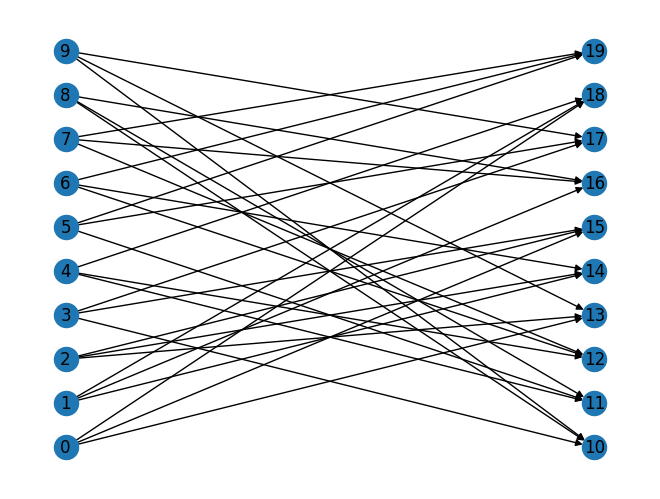

In [48]:
data = Data(edge_index=ramanujan_edge_index, num_nodes=NUM_NODES * 2)
nx_graph = convert.to_networkx(data)
pos = nx.bipartite_layout(nx_graph, [i for i in range(NUM_NODES)])
nx.draw(nx_graph, pos=pos, with_labels=True)

In [298]:
adj = nx.adjacency_matrix(nx_graph.to_undirected())
print(np.sort(np.linalg.eigvals(adj.toarray())))

[-3.00000000e+00+0.00000000e+00j -2.79889056e+00+0.00000000e+00j
 -2.48583526e+00+0.00000000e+00j -2.42221335e+00+0.00000000e+00j
 -2.10925960e+00+0.00000000e+00j -1.90349354e+00+0.00000000e+00j
 -1.78446025e+00+0.00000000e+00j -1.40750069e+00+0.00000000e+00j
 -1.17124136e+00+0.00000000e+00j -1.00220014e+00+0.00000000e+00j
 -5.92818037e-01+0.00000000e+00j -3.93004039e-01+0.00000000e+00j
 -1.85243642e-16-6.85698004e-17j -1.85243642e-16+6.85698004e-17j
 -7.10743575e-17+0.00000000e+00j  1.46299621e-16+0.00000000e+00j
  1.69030334e-16-1.21231484e-16j  1.69030334e-16+1.21231484e-16j
  3.93004039e-01+0.00000000e+00j  5.92818037e-01+0.00000000e+00j
  1.00220014e+00+0.00000000e+00j  1.17124136e+00+0.00000000e+00j
  1.40750069e+00+0.00000000e+00j  1.78446025e+00+0.00000000e+00j
  1.90349354e+00+0.00000000e+00j  2.10925960e+00+0.00000000e+00j
  2.42221335e+00+0.00000000e+00j  2.48583526e+00+0.00000000e+00j
  2.79889056e+00+0.00000000e+00j  3.00000000e+00+0.00000000e+00j]


###  Test out Expander Nodes are Added Correctly when Batching

In [83]:
from exp.expander_graph_generation import add_expander_edges_via_perfect_matchings
from ogb.graphproppred import PygGraphPropPredDataset
from functools import partial
from torch_geometric.loader import DataLoader

In [84]:
expander_graph_generation_fn = partial(add_expander_edges_via_perfect_matchings, 3, "mol")

### automatic dataloading and splitting
dataset = PygGraphPropPredDataset(name="ogbg-molhiv", pre_transform=expander_graph_generation_fn)

Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:00<00:00, 56793.77it/s]


Converting graphs into PyG objects...


100%|██████████| 41127/41127 [00:02<00:00, 18969.84it/s]


Saving...


Done!


In [85]:
split_idx = dataset.get_idx_split()
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=3, shuffle=True,
                              num_workers=4)
batch = next(iter(train_loader))

In [86]:
third_graph_nodes = batch.x[batch.batch == 2]

In [87]:
third_graph_mask = batch.expander_node_mask[batch.batch == 2]
third_graph_mask

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [88]:
batch.edge_attr.shape

torch.Size([172, 3])

In [89]:
batch.edge_index.shape

torch.Size([2, 172])

In [90]:
batch.edge_attr.shape

torch.Size([172, 3])

In [91]:
batch.expander_edge_index.shape

torch.Size([2, 246])

In [92]:
batch.expander_edge_index[0][:31*3]

tensor([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,
         6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11,
        12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 32, 32, 32, 33, 33, 33,
        34, 34, 34, 35, 35, 35, 36, 36, 36, 37, 37, 37, 38, 38, 38, 39, 39, 39,
        40, 40, 40, 41, 41, 41, 42, 42, 42, 43, 43, 43, 44, 44, 44, 45, 45, 45,
        46, 46, 46])

In [93]:
batch.expander_edge_index[1][:31*3]

tensor([ 21,  22,  25,  18,  24,  28,  16,  24,  27,  18,  20,  29,  19,  20,
         23,  16,  27,  28,  22,  23,  30,  26,  29,  30,  17,  23,  25,  19,
         21,  31,  16,  17,  30,  24,  27,  31,  17,  19,  26,  21,  22,  31,
         18,  20,  28,  25,  26,  29,  94,  97, 100,  92,  99, 111,  77,  78,
        108,  95,  98, 114,  81,  87, 119,  79,  87, 115, 114, 118, 119,  81,
         96, 100, 101, 108, 109,  77,  80, 109,  92,  97, 112,  82,  85,  95,
         76,  84, 107,  87,  93, 113,  93,  98,  99])

In [94]:
torch.stack((batch.expander_edge_index[0][:10*3], batch.expander_edge_index[1][:10*3])).shape

torch.Size([2, 30])

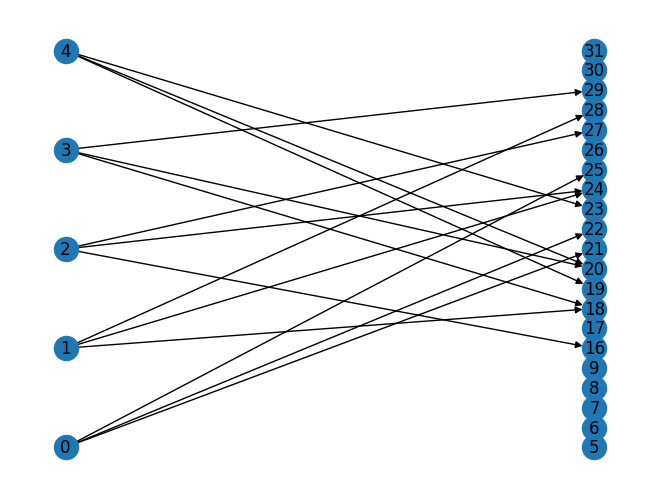

In [95]:
data = Data(edge_index=torch.stack((batch.expander_edge_index[0][:10*3], batch.expander_edge_index[1][:10*3])), num_nodes=10)
nx_graph = convert.to_networkx(data)
pos = nx.bipartite_layout(nx_graph, [i for i in range(5)])
nx.draw(nx_graph, pos=pos, with_labels=True)

In [9]:
first_node_idx = torch.min(torch.where(batch.batch == 2)[0])

In [10]:
third_graph_original_connectivity = batch.edge_index - first_node_idx
source_nodes = third_graph_original_connectivity[0]
destination_nodes = third_graph_original_connectivity[1]
source_nodes = source_nodes[torch.where(source_nodes >= 0)[0]]
destination_nodes = destination_nodes[torch.where(destination_nodes >= 0)[0]]
original_connectivity = torch.concat((source_nodes[None, ...], destination_nodes[None, ...]), dim=0)
num_edges = len(torch.transpose(original_connectivity, 0, 1))
non_batch_original_connectivity = batch.old_edges[-num_edges:]
print(f"Unbatched is equal to batched: {torch.equal(non_batch_original_connectivity, torch.transpose(original_connectivity, 0, 1))}")

AttributeError: 'GlobalStorage' object has no attribute 'old_edges'

In [49]:
third_graph_expander_connectivity = batch.expander_edge_index - first_node_idx
source_nodes = third_graph_expander_connectivity[0]
destination_nodes = third_graph_expander_connectivity[1]
source_nodes = source_nodes[torch.where(source_nodes >= 0)[0]]
destination_nodes = destination_nodes[torch.where(destination_nodes >= 0)[0]]
expander_connectivity = torch.concat((source_nodes[None, ...], destination_nodes[None, ...]), dim=0)

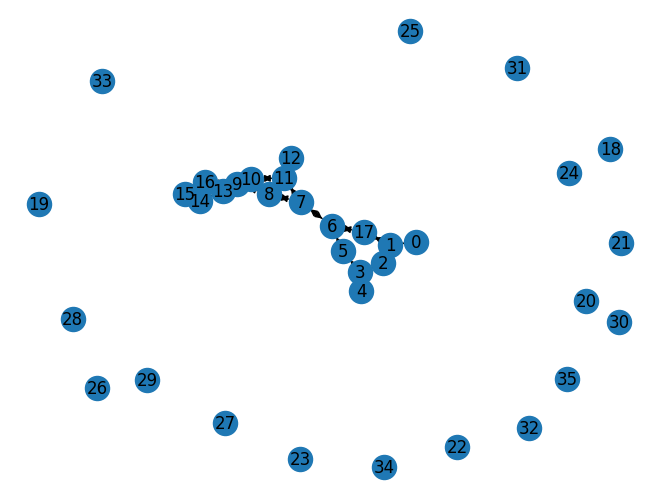

In [50]:
data = Data(edge_index=original_connectivity, num_nodes=third_graph_nodes.shape[0])
nx_graph = convert.to_networkx(data)
nx.draw(nx_graph, with_labels=True)

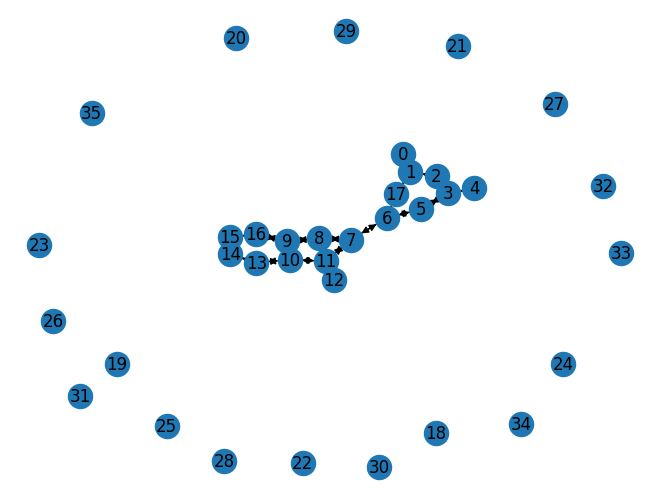

In [53]:
data = Data(edge_index=torch.transpose(non_batch_original_connectivity, 0, 1), num_nodes=third_graph_nodes.shape[0])
nx_graph = convert.to_networkx(data)
nx.draw(nx_graph, with_labels=True)

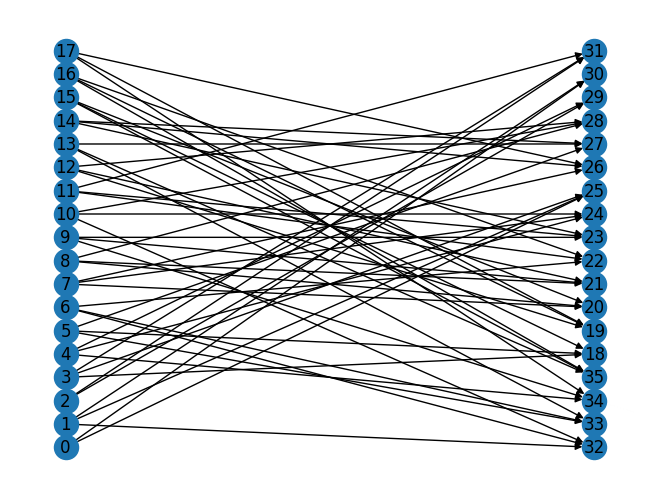

In [51]:
data = Data(edge_index=expander_connectivity, num_nodes=third_graph_nodes.shape[0])
nx_graph = convert.to_networkx(data)
pos = nx.bipartite_layout(nx_graph, [i for i in range(int(third_graph_nodes.shape[0]/2))])
nx.draw(nx_graph, pos=pos, with_labels=True)

### Ramanujan Testing

In [22]:
from exp.expander_graph_generation import add_expander_edges_via_ramanujan_bipartite_graph
from ogb.graphproppred import PygGraphPropPredDataset
from functools import partial
from torch_geometric.loader import DataLoader

In [23]:
expander_graph_generation_fn = partial(add_expander_edges_via_ramanujan_bipartite_graph, 3, 42, False)

In [24]:
dataset = PygGraphPropPredDataset(name="ogbg-molhiv", pre_transform=expander_graph_generation_fn)

Downloaded 0.00 GB: 100%|██████████| 3/3 [00:09<00:00,  3.24s/it]
Processing...


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:02<00:00, 16398.24it/s]


Converting graphs into PyG objects...


100%|██████████| 41127/41127 [00:06<00:00, 6552.13it/s] 


Saving...


Done!


In [26]:
split_idx = dataset.get_idx_split()
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=2, shuffle=True, num_workers=4)
batch = next(iter(train_loader))

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
  File "/usr/local/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    self = reduction.pickle.load(from_parent)
  File "/Users/thomaschristie/Documents/GitHub.nosync/higher-order-EGP/venv/lib/python3.9/site-packages/ogb/graphproppred/__init__.py", line 5, in <module>
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/thomaschristie/Documents/GitHub.nosync/higher-order-EGP/venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1120, in _try_get_data
    def _try_get_data(self, timeout=_utils.MP_STATUS_CHECK_INTERVAL):
  File "/usr/local/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/queues.py", line 113, in get
    if not self._poll(timeout):
  File "/usr/local/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/usr/local/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/connection.py", line 424, in _poll
    r = wait([self], timeout)
  File "/usr/local/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "

In [9]:
batch.edge_index

tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          3, 10, 10, 11, 10, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18,
         18, 19, 18, 20, 20, 21, 20, 22, 12,  1, 22, 15,  9,  4, 46, 47, 47, 48,
         48, 49, 49, 50, 50, 51, 51, 52, 52, 53, 50, 54, 54, 55, 54, 56, 56, 57,
         57, 58, 58, 59, 59, 60, 60, 61, 61, 62, 62, 63, 63, 64, 64, 65, 65, 66,
         66, 67, 67, 68, 68, 69, 67, 70, 68, 50, 70, 56, 70, 60, 66, 61],
        [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  3, 11, 10, 12, 10, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18, 17,
         19, 18, 20, 18, 21, 20, 22, 20,  1, 12, 15, 22,  4,  9, 47, 46, 48, 47,
         49, 48, 50, 49, 51, 50, 52, 51, 53, 52, 54, 50, 55, 54, 56, 54, 57, 56,
         58, 57, 59, 58, 60, 59, 61, 60, 62, 61, 63, 62, 64, 63, 65, 64, 66, 65,
         67, 66, 68, 67, 69, 68, 70, 67, 50, 68, 56, 70, 60, 70, 61, 66]])

In [10]:
batch.expander_edge_index

tensor([[ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,
          6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11,
         12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17,
         18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 46, 46, 46,
         47, 47, 47, 48, 48, 48, 49, 49, 49, 50, 50, 50, 51, 51, 51, 52, 52, 52,
         53, 53, 53, 54, 54, 54, 55, 55, 55, 56, 56, 56, 57, 57, 57, 58, 58, 58,
         59, 59, 59, 60, 60, 60, 61, 61, 61, 62, 62, 62, 63, 63, 63, 64, 64, 64,
         65, 65, 65, 66, 66, 66, 67, 67, 67, 68, 68, 68, 69, 69, 69, 70, 70, 70],
        [25, 38, 39, 28, 36, 37, 35, 40, 45, 24, 29, 32, 33, 34, 42, 27, 41, 44,
         23, 30, 31, 26, 32, 43, 26, 33, 39, 24, 38, 41, 27, 28, 42, 25, 29, 34,
         23, 35, 44, 30, 31, 37, 36, 40, 43, 36, 38, 45, 25, 29, 30, 23, 40, 44,
         28, 32, 39, 27, 33, 43, 26, 35, 41, 24, 31, 37, 34, 42, 45, 80, 83, 87,
         77, 89, 90, 76, 81

In [13]:
batch.expander_node_mask

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])

In [14]:
batch.num_nodes

96